# End-to-end tutorial (LSTM)
---
현대차 제공 LSTM End to end 튜토리얼

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_preprocess import PreprocessData

from sklearn.svm import OneClassSVM
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

## Prepare Dataset

In [2]:
root_dir = '../datasets'
fname = 'pu_batt_sample10.csv'
dataset_dir = os.path.join(root_dir, fname)

In [3]:
lstm_dp = PreprocessData(dataset_dir, 'lstm')
lstm_scaled_vol_data, lstm_scaled_other_data = lstm_dp.preprocess_data()
print(lstm_scaled_vol_data.shape, lstm_scaled_other_data.shape)

(129663, 90) (129663, 10)


## Dimensionality Reduction

In [4]:
# %% 모델학습
# AE 전셀전압 차원축소
inputs = Input(shape=(lstm_scaled_vol_data.shape[1],))
encoded = Dense(64, activation='tanh', name="encode1")(inputs)
encoded = Dense(32, activation='tanh', name="encode2")(encoded)
encoded = Dense(10, activation='tanh', name="encode3")(encoded)
decoded = Dense(32, activation='tanh', name="decode1")(encoded)
decoded = Dense(64, activation='tanh', name="decode2")(decoded)
decoded = Dense(lstm_scaled_vol_data.shape[1], name="decode3")(decoded)
autoencoder = Model(inputs, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90)]              0         
                                                                 
 encode1 (Dense)             (None, 64)                5824      
                                                                 
 encode2 (Dense)             (None, 32)                2080      
                                                                 
 encode3 (Dense)             (None, 10)                330       
                                                                 
 decode1 (Dense)             (None, 32)                352       
                                                                 
 decode2 (Dense)             (None, 64)                2112      
                                                                 
 decode3 (Dense)             (None, 90)                5850  

In [5]:
# %% Early stopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# AE 모델 컴파일 및 학습
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
autoencoder.compile(optimizer=optimizer, loss='mse')
history = autoencoder.fit(lstm_scaled_vol_data, lstm_scaled_vol_data, batch_size=32, epochs=3, validation_split=0.2,
                          callbacks=[early_stopping])  # Early stopping 콜백 추가

Epoch 1/3
3242/3242 [==============================] - 3s 985us/step - loss: 0.0026 - val_loss: 7.1692e-05
Epoch 2/3
3242/3242 [==============================] - 3s 1ms/step - loss: 4.0099e-05 - val_loss: 5.0459e-05
Epoch 3/3
3242/3242 [==============================] - 3s 981us/step - loss: 3.6107e-05 - val_loss: 5.0315e-06


In [6]:
for idx, layer in enumerate(autoencoder.layers):
    print(idx, layer.name, layer)

0 input_1 <keras.src.engine.input_layer.InputLayer object at 0x135808a30>
1 encode1 <keras.src.layers.core.dense.Dense object at 0x141f3b160>
2 encode2 <keras.src.layers.core.dense.Dense object at 0x141f3bf70>
3 encode3 <keras.src.layers.core.dense.Dense object at 0x141f3bf10>
4 decode1 <keras.src.layers.core.dense.Dense object at 0x141da46a0>
5 decode2 <keras.src.layers.core.dense.Dense object at 0x141da44f0>
6 decode3 <keras.src.layers.core.dense.Dense object at 0x141da4460>


In [7]:
encoder_model = Model(autoencoder.layers[0].input, autoencoder.layers[3].output)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90)]              0         
                                                                 
 encode1 (Dense)             (None, 64)                5824      
                                                                 
 encode2 (Dense)             (None, 32)                2080      
                                                                 
 encode3 (Dense)             (None, 10)                330       
                                                                 
Total params: 8234 (32.16 KB)
Trainable params: 8234 (32.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
latent_vector = encoder_model.predict(lstm_scaled_vol_data)

4052/4052 [==============================] - 1s 336us/step


## Train LSTM model

### Preprocess data

In [9]:
# %%
df_latent_vector = pd.DataFrame(latent_vector)

# LSTM_AE 입력 데이터
ad_train_data = pd.concat([lstm_scaled_other_data, df_latent_vector], axis=1)

In [10]:
# %% 입력데이터 윈도윙
window_size = 200
stride = 100
windowed_data = []

for i in range(int(max(ad_train_data['cycle_num'])) + 1):
    window1 = ad_train_data.loc[ad_train_data['cycle_num'] == i]

    for j in range(0, len(window1) - window_size, stride):
        window2 = window1.iloc[j:j + window_size]
        windowed_data.append(window2)

np_windows = np.array(windowed_data)
# cycle_num 컬럼 삭제
train_data = np.delete(np_windows, [9], axis=2)

In [21]:
ad_train_data.loc[ad_train_data['cycle_num'] == 1]

,msr_data.ibm,msr_data.r_isol,msr_data.vb_max,msr_data.vb_min,msr_tbmax_raw,msr_tbmin_raw,SOC,delta_voltage,delta_temp,cycle_num,0,1,2,3,4,5,6,7,8,9
112323,0.993347,0.0,0.364185,0.362173,0.651515,0.763889,0.459746,0.5,0.027778,1.0,0.178869,0.189242,-0.962919,0.330895,-0.817248,-0.150038,0.390825,0.005866,0.235438,-0.186290
112324,0.994677,0.0,0.364185,0.362173,0.651515,0.763889,0.459746,0.5,0.027778,1.0,0.178345,0.190299,-0.962866,0.330352,-0.817157,-0.149989,0.391555,0.003831,0.234029,-0.185829
112325,0.995343,0.0,0.364185,0.364185,0.651515,0.763889,0.459746,0.4,0.027778,1.0,0.178679,0.190255,-0.962937,0.330453,-0.816842,-0.149733,0.391584,0.003075,0.234045,-0.185794
112326,0.995343,0.0,0.364185,0.362173,0.651515,0.763889,0.459746,0.5,0.027778,1.0,0.179762,0.190029,-0.962999,0.330712,-0.816793,-0.148719,0.391876,0.002474,0.233523,-0.185828
112327,0.995343,0.0,0.362173,0.362173,0.651515,0.763889,0.459746,0.4,0.027778,1.0,0.179022,0.190603,-0.962952,0.331410,-0.817016,-0.150220,0.391361,0.003242,0.234635,-0.185753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129658,0.592814,0.0,0.839034,0.841046,0.939394,1.000000,0.851695,0.3,0.083333,1.0,-0.132944,0.087099,-0.577190,-0.129203,-0.870472,-0.581084,0.617345,0.349823,0.595218,-0.524977
129659,0.592149,0.0,0.839034,0.843058,0.939394,1.000000,0.851695,0.2,0.083333,1.0,-0.132806,0.086710,-0.577390,-0.129419,-0.870590,-0.580587,0.617017,0.350955,0.596226,-0.525566
129660,0.592814,0.0,0.837022,0.841046,0.954545,1.000000,0.851695,0.2,0.111111,1.0,-0.132002,0.086907,-0.577320,-0.128970,-0.870299,-0.581141,0.617286,0.351106,0.595929,-0.525245
129661,0.592814,0.0,0.839034,0.841046,0.954545,1.000000,0.851695,0.3,0.111111,1.0,-0.132791,0.086949,-0.577147,-0.129423,-0.870724,-0.580742,0.617423,0.351090,0.595582,-0.524878


### Build  model

In [11]:
# %% 이상탐지 모델 설계
inputs = Input(shape=(train_data.shape[1], train_data.shape[-1]))
encoded = LSTM(64, activation='tanh', return_sequences=True)(inputs)
encoded = Dropout(0.2)(encoded)
encoded = LSTM(32, activation='tanh', return_sequences=True)(encoded)
encoded = LSTM(8, activation='tanh', return_sequences=False)(encoded)
decoded = RepeatVector(train_data.shape[1])(encoded)
decoded = LSTM(32, activation='tanh', return_sequences=True)(decoded)
decoded = LSTM(64, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(train_data.shape[-1]))(decoded)
LSTM_autoencoder = Model(inputs, decoded)
LSTM_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 19)]         0         
                                                                 
 lstm (LSTM)                 (None, 200, 64)           21504     
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 200, 32)           12416     
                                                                 
 lstm_2 (LSTM)               (None, 8)                 1312      
                                                                 
 repeat_vector (RepeatVecto  (None, 200, 8)            0         
 r)                                                              
                                                           

### Train  model

In [12]:
# %% Early stopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
LSTM_autoencoder.compile(optimizer=optimizer, loss='mse')

history = LSTM_autoencoder.fit(train_data, train_data, batch_size=32, epochs=3, validation_split=0.2,
                               callbacks=[early_stopping])  # Early stopping 콜백 추가

Epoch 1/3
10/10 [==============================] - 6s 302ms/step - loss: 0.2067 - val_loss: 0.1224
Epoch 2/3
10/10 [==============================] - 2s 211ms/step - loss: 0.0492 - val_loss: 0.0415
Epoch 3/3
10/10 [==============================] - 2s 212ms/step - loss: 0.0332 - val_loss: 0.0546


## Plot Result

12/12 [==============================] - 1s 49ms/step


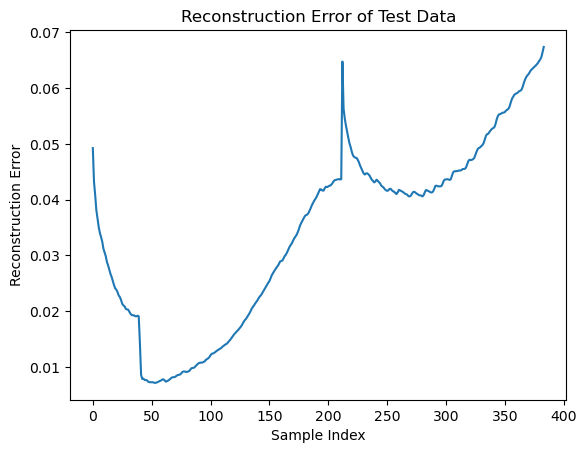

In [13]:
# 테스트 데이터에 대한 예측 수행
decoded_original = LSTM_autoencoder.predict(train_data)
mse = np.mean(np.square(train_data - decoded_original), axis=(1, 2))

# %%
# Reconstruction error를 그래프로 그리기
plt.plot(mse)
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error of Test Data')
plt.show()